<a href="https://colab.research.google.com/github/irfanrasheedkc/Potato-disease-classifier/blob/main/Preprocessing%20in%20colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt

In [3]:

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Potato-disease-classifier/PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE , IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

In [8]:
# fig, axes = plt.subplots(3, 4, figsize=(10, 10))

# for i, ax in enumerate(axes.flat):
#     ax.imshow(image_batch[i].numpy().astype("uint8"))
#     ax.set_title(class_names[label_batch[i]])
#     ax.axis('off')


In [9]:
def get_dataset_partition_tf(ds , train_split=0.8 , val_split=0.1 , test_split=0.1 , shuffle=True , shuffle_size=1000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size , seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds , val_ds , test_ds

In [10]:
train_ds , val_ds , test_ds = get_dataset_partition_tf(dataset)

In [11]:
len(train_ds)

54

In [12]:
len(val_ds)

6

In [13]:
len(test_ds)

8

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE , IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 382s 189ms/step - loss: 0.9152 - accuracy: 0.4809 - val_loss: 0.9296 - val_accuracy: 0.5260
Epoch 2/50
54/54 [==============================] - 3s 62ms/step - loss: 0.7674 - accuracy: 0.6163 - val_loss: 1.0513 - val_accuracy: 0.5729
Epoch 3/50
54/54 [==============================] - 4s 67ms/step - loss: 0.5302 - accuracy: 0.7847 - val_loss: 0.4263 - val_accuracy: 0.8177
Epoch 4/50
54/54 [==============================] - 3s 63ms/step - loss: 0.3727 - accuracy: 0.8461 - val_loss: 0.3266 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 3s 58ms/step - loss: 0.2571 - accuracy: 0.8987 - val_loss: 0.2032 - val_accuracy: 0.9010
Epoch 6/50
54/54 [==============================] - 3s 59ms/step - loss: 0.1381 - accuracy: 0.9462 - val_loss: 0.0742 - val_accuracy: 0.9896
Epoch 7/50
54/54 [==============================] - 3s 60ms/step - loss: 0.0988 - accuracy: 0.9653 - val_loss: 0.0743 - val_accuracy: 0.9792
Epoch 8/50

In [21]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 30ms/step - loss: 0.0206 - accuracy: 0.9922


In [22]:
scores

[0.020605476573109627, 0.9921875]

In [23]:
history


In [24]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [25]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
type(history.history['loss'])


list

In [27]:
len(history.history['loss'])


50

In [28]:
history.history['loss'][:5] # show loss for first 5 epochs


[0.9152182936668396,
 0.7673735618591309,
 0.5301759839057922,
 0.37266260385513306,
 0.2570893168449402]

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

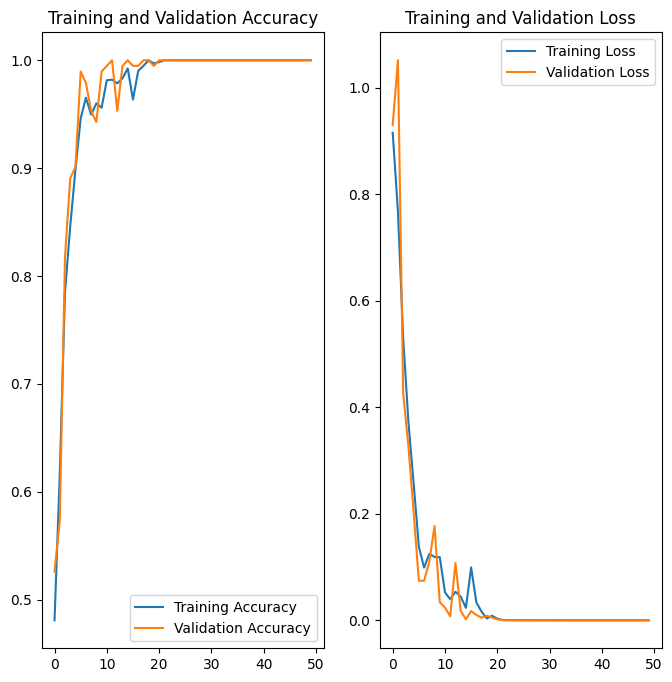

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
first image's actpual label: Potato___Late_blight
1/1 [==============================] - 0s 39ms/step
Predicted label:  Potato___Late_blight


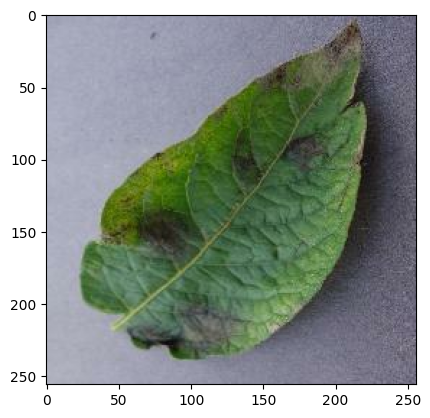

In [33]:
import numpy as np
for images_batch , labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("first image's actpual label:" , class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("Predicted label: " , class_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


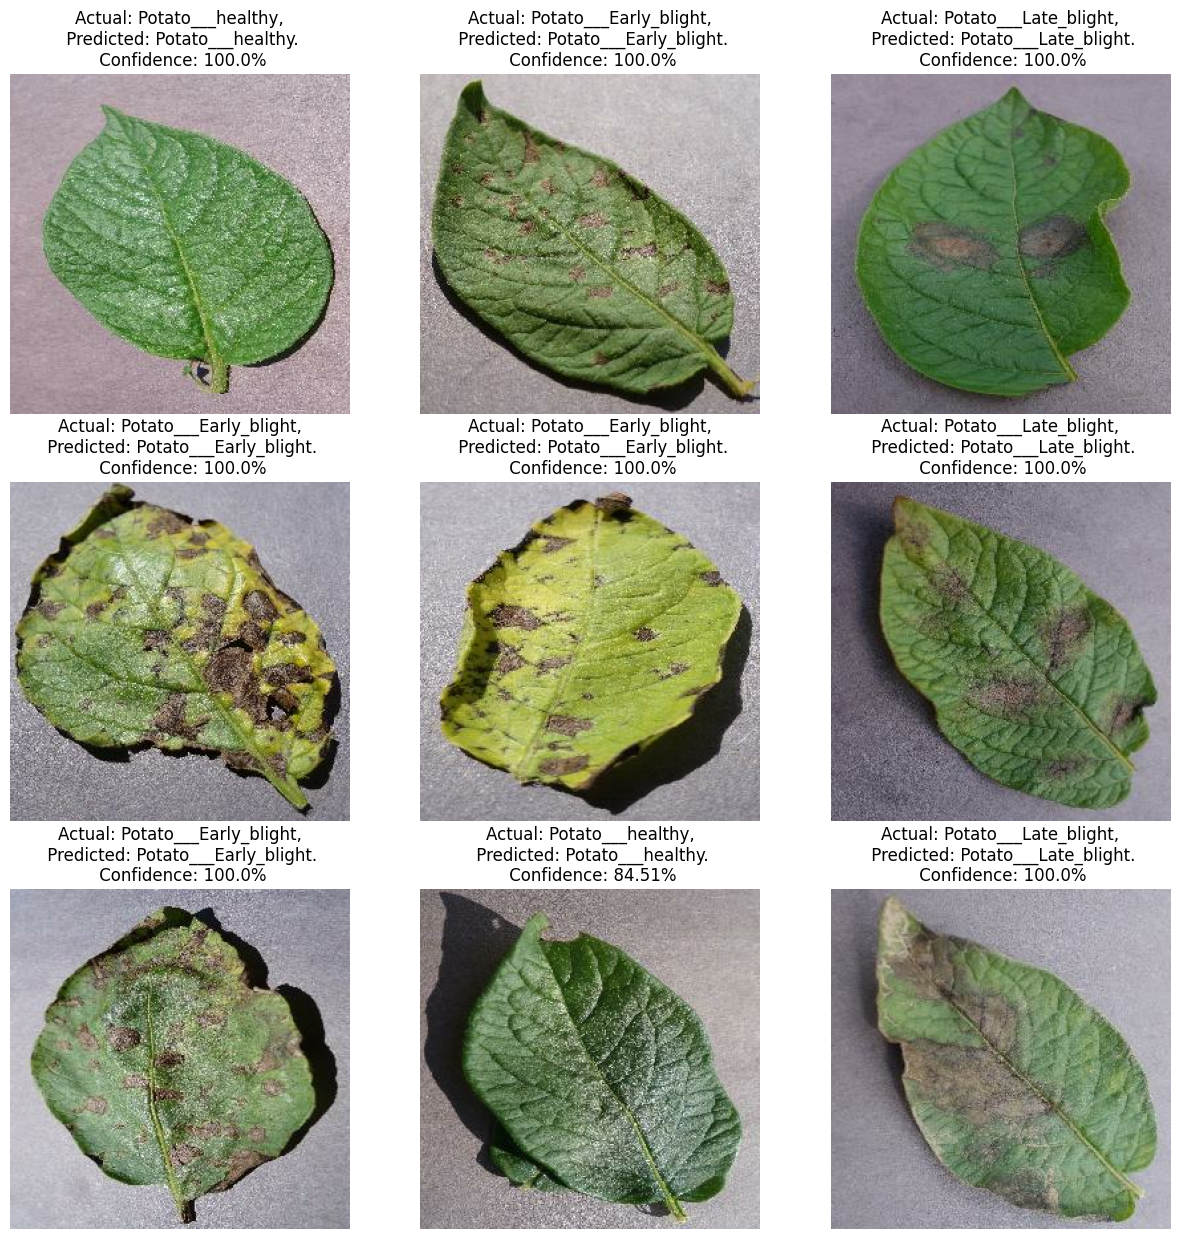

In [35]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
import os
model_version = max([int(i) for i in os.listdir('../models')])

In [36]:
model.save(f'../models/{model_version}')